## RAG Stages

* Indexing
* Retrieval
* Generation

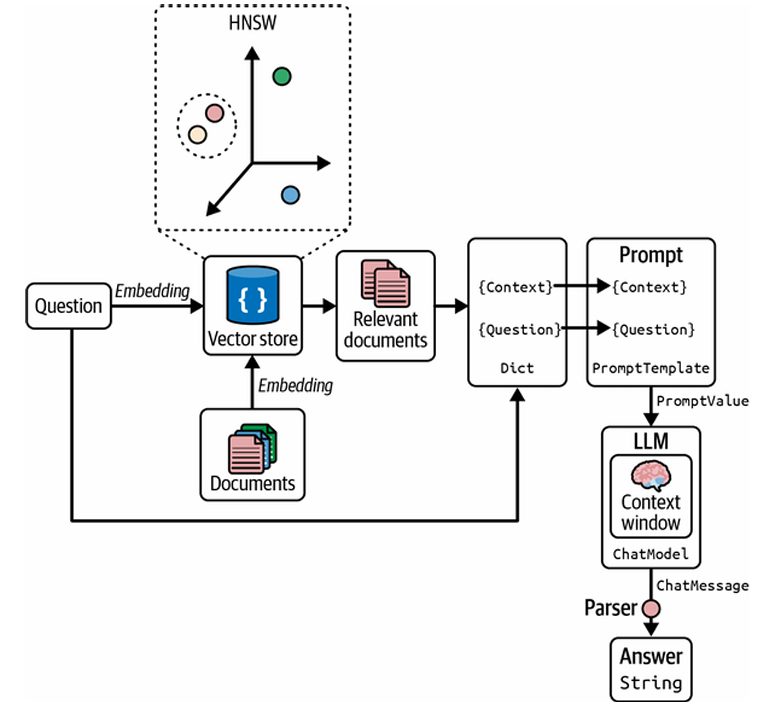

### Indexing

In [9]:
from langchain_community.document_loaders import TextLoader
from langchain_ollama import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import OpenSearchVectorSearch
import dotenv
import os

dotenv.load_dotenv()
os_key = os.getenv("OPENSEARCH_INITIAL_ADMIN_PASSWORD")


# Load the document, split it into chunks
raw_documents = TextLoader('../data/test.txt').load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=30, 
    chunk_overlap=8)
documents = text_splitter.split_documents(raw_documents)

# embed each chunk and insert it into the vector store
model = OllamaEmbeddings(
    base_url='http://127.0.0.1:11434',
    model="qwen:0.5b"
)
docsearch = OpenSearchVectorSearch.from_documents(
    documents,
    model,
    opensearch_url="https://localhost:9200",
    http_auth=("admin", os_key),
    use_ssl=False,
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False,
    engine="faiss",
)

In [10]:
documents

[Document(metadata={'source': '../data/test.txt'}, page_content='Test text'),
 Document(metadata={'source': '../data/test.txt'}, page_content='And Chunks just in case.'),
 Document(metadata={'source': '../data/test.txt'}, page_content='case. Fatal'),
 Document(metadata={'source': '../data/test.txt'}, page_content='Or not'),
 Document(metadata={'source': '../data/test.txt'}, page_content='Great President and friend')]

### Retrieval

In [11]:
retriever = docsearch.as_retriever(search_kwargs={"k": 2})

# fetch the 2 most relevant documents
docs = retriever.invoke("""Who are the key figures in the ancient greek history 
    of philosophy?""")

### Generation

In [13]:
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate


prompt = ChatPromptTemplate.from_template("""Answer the question based only on 
    the following context:
{context}

Question: {question}
""")

llm = ChatOllama(
    base_url='http://127.0.0.1:11434',
    model="qwen:0.5b",
    temperature=0,
)

chain = prompt | llm

# fetch relevant documents 
docs = retriever.get_relevant_documents("""Who are the key figures in the 
    ancient greek history of philosophy?""")

# run
chain.invoke({"context": docs,"question": """Who are the key figures in the 
    ancient greek history of philosophy?"""})

C:\Users\User\AppData\Local\Temp\ipykernel_13036\4060200224.py:21: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents("""Who are the key figures in the


AIMessage(content='The key figures in the ancient Greek history of philosophy include:\n\n1. Plato - one of the most important philosophers in history.\n\n2. Aristotle - another influential philosopher who developed a system of knowledge based on reason and observation.\n\n3. Confucius - a Chinese philosopher who developed a system of moral principles based on respect, honesty, and integrity.\n\nThese key figures played significant roles in shaping the ancient Greek history of philosophy.', additional_kwargs={}, response_metadata={'model': 'qwen:0.5b', 'created_at': '2025-08-02T01:27:04.318278Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3349194600, 'load_duration': 33101900, 'prompt_eval_count': 168, 'prompt_eval_duration': 1204521700, 'eval_count': 85, 'eval_duration': 2108074700, 'model_name': 'qwen:0.5b'}, id='run--70e1f300-95c7-47ec-bb40-d9b2d1a48a18-0', usage_metadata={'input_tokens': 168, 'output_tokens': 85, 'total_tokens': 253})

In [14]:
from langchain_core.runnables import chain

retriever = docsearch.as_retriever()

prompt = ChatPromptTemplate.from_template("""Answer the question based only on 
    the following context:
{context}

Question: {question}
""")

@chain
def qa(input):
    # fetch relevant documents 
    docs = retriever.get_relevant_documents(input)
    # format prompt
    formatted = prompt.invoke({"context": docs, "question": input})
    # generate answer
    answer = llm.invoke(formatted)
    return answer

# run
qa.invoke("Who are the key figures in the ancient greek history of philosophy?")

AIMessage(content='The key figures in the ancient Greek history of philosophy include Plato, Aristotle, and Socrates.', additional_kwargs={}, response_metadata={'model': 'qwen:0.5b', 'created_at': '2025-08-02T01:28:58.4301028Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2613635500, 'load_duration': 27626000, 'prompt_eval_count': 282, 'prompt_eval_duration': 2006099300, 'eval_count': 20, 'eval_duration': 578467300, 'model_name': 'qwen:0.5b'}, id='run--a0b05b74-4019-43f9-82dc-81327f965cf8-0', usage_metadata={'input_tokens': 282, 'output_tokens': 20, 'total_tokens': 302})

In [15]:
##### Traditional flow, returning answer and docs #####

@chain
def qa(input):
    # fetch relevant documents 
    docs = retriever.get_relevant_documents(input)
    # format prompt
    formatted = prompt.invoke({"context": docs, "question": input})
    # generate answer
    answer = llm.invoke(formatted)
    return {"answer": answer, "docs": docs}

#### RAG application

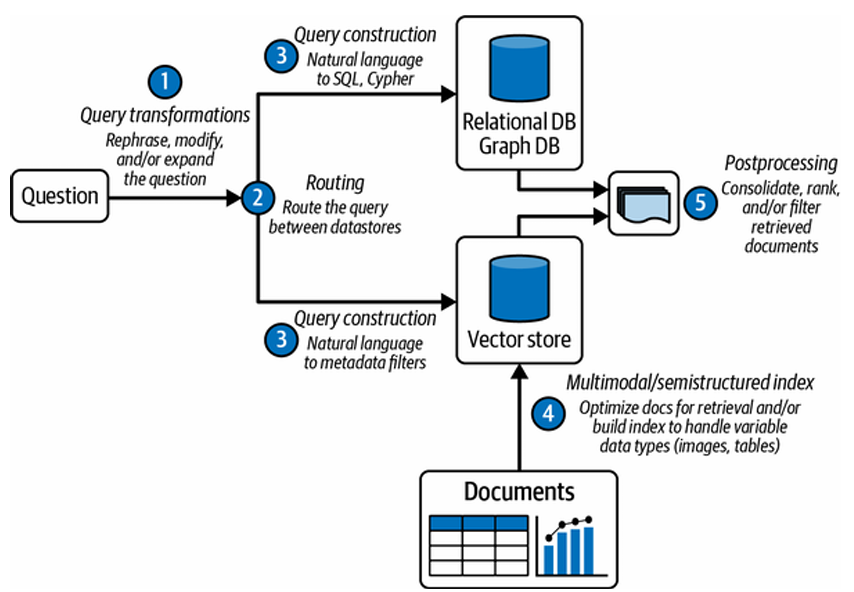